In [55]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

In [56]:
data = pd.read_csv('https://drive.google.com/uc?id=16w8ahgJvh1uQifglFatoI05UjLcLDcoO')
data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


<bound method NDFrame.head of              date  store  sales
0      2013-01-01      1   1316
1      2013-01-01      2   1742
2      2013-01-01      3   1588
3      2013-01-01      4   1423
4      2013-01-01      5   1032
...           ...    ...    ...
18255  2017-12-31      6   2009
18256  2017-12-31      7   1831
18257  2017-12-31      8   3205
18258  2017-12-31      9   2774
18259  2017-12-31     10   2939

[18260 rows x 3 columns]>

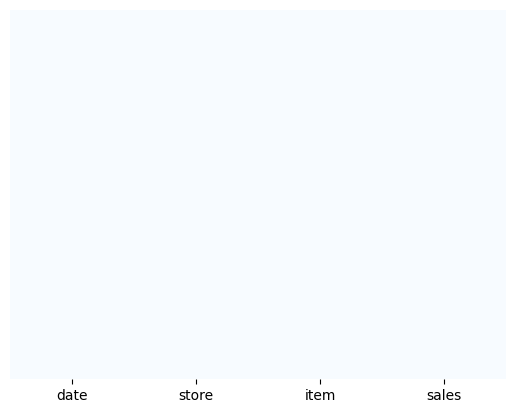

In [57]:
sns.heatmap(data.isnull(), yticklabels = False, cbar = False, cmap="Blues")
data.isnull().sum()
# Elimina la columna 'item'
data = data.drop(columns=['item'])

# Agrupa por 'date' y 'store' y suma las ventas
data = data.groupby(['date', 'store']).sum().reset_index()

data.head

In [58]:
data.columns

Index(['date', 'store', 'sales'], dtype='object')

date
2013-01-01    1316
2013-01-02    1264
2013-01-03    1305
2013-01-04    1452
2013-01-05    1499
Name: sales, dtype: int64

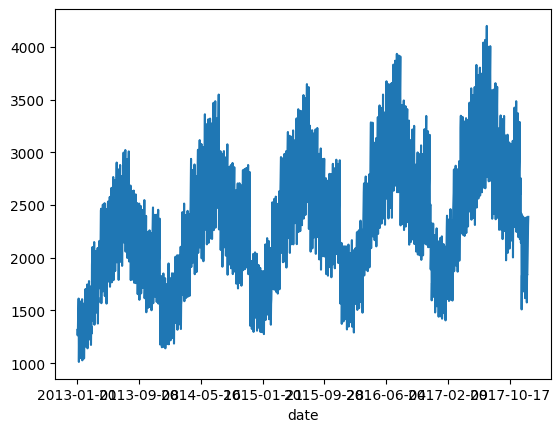

In [59]:
# univariate dataframe: sales vs Time
store_1_data = data[data['store'] == 1]
uni_data_data = store_1_data['sales']
uni_data_data.index = store_1_data['date']
uni_data_data.plot()
uni_data_data.head()

In [60]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler  # Agrega esta línea para importar StandardScaler


# Supongamos que 'data' es tu DataFrame original con datos de ventas.
# Asegúrate de que la columna 'date' esté en formato de fecha.
data['date'] = pd.to_datetime(data['date'])

# Divide los datos en conjuntos de entrenamiento, validación y prueba
fecha_fin_prueba = data['date'].max()
fecha_inicio_prueba = fecha_fin_prueba - pd.DateOffset(months=3)
fecha_inicio_validacion = fecha_inicio_prueba - pd.DateOffset(months=6)

conjunto_entrenamiento = data[(data['date'] < fecha_inicio_validacion)]
conjunto_validacion = data[(data['date'] >= fecha_inicio_validacion) & (data['date'] < fecha_inicio_prueba)]
conjunto_prueba = data[(data['date'] >= fecha_inicio_prueba) & (data['date'] <= fecha_fin_prueba)]

# Escala los datos de ventas para tener una media de 0 y desviación estándar de 1
scaler = StandardScaler()
conjunto_entrenamiento['sales'] = scaler.fit_transform(conjunto_entrenamiento['sales'].values.reshape(-1, 1))
conjunto_validacion['sales'] = scaler.transform(conjunto_validacion['sales'].values.reshape(-1, 1))
conjunto_prueba['sales'] = scaler.transform(conjunto_prueba['sales'].values.reshape(-1, 1))

# Genera secuencias para el conjunto de entrenamiento y validación
def generar_secuencias(datos, ventana_historica):
    secuencias = []
    for i in range(len(datos) - ventana_historica - 90):  # 90 días para pronosticar 3 meses
        secuencia = datos[i:i+ventana_historica]
        objetivo = datos[i+ventana_historica:i+ventana_historica+90]
        secuencias.append((secuencia, objetivo))
    return secuencias

ventana_historica = 90  # Por ejemplo, una ventana de 90 días para datos diarios.
secuencias_entrenamiento = generar_secuencias(conjunto_entrenamiento['sales'].values, ventana_historica)
secuencias_validacion = generar_secuencias(conjunto_validacion['sales'].values, ventana_historica)
secuencias_prueba = generar_secuencias(conjunto_prueba['sales'].values, ventana_historica)

# Convierte las secuencias en matrices NumPy
X_entrenamiento, y_entrenamiento = zip(*secuencias_entrenamiento)
X_validacion, y_validacion = zip(*secuencias_validacion)
X_prueba, y_prueba = zip(*secuencias_prueba)

X_entrenamiento = np.array(X_entrenamiento).reshape(len(X_entrenamiento), ventana_historica, 1)
y_entrenamiento = np.array(y_entrenamiento)
X_validacion = np.array(X_validacion).reshape(len(X_validacion), ventana_historica, 1)
y_validacion = np.array(y_validacion)
X_prueba = np.array(X_prueba).reshape(len(X_prueba), ventana_historica, 1)
y_prueba = np.array(y_prueba)

# Define el modelo
modelo = Sequential()
modelo.add(LSTM(units=64, input_shape=(ventana_historica, 1), return_sequences=False))
modelo.add(Dropout(0.2))
modelo.add(Dense(units=90, activation='linear'))  # 90 días para pronosticar 3 meses

# Optimizador
opt = Adam(learning_rate=0.001)

# Compila el modelo
modelo.compile(optimizer=opt, loss=Huber(delta=1.0))

# Muestra un resumen del modelo
modelo.summary()


C:\Users\marco\AppData\Local\Temp\ipykernel_61536\1614382901.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conjunto_entrenamiento['sales'] = scaler.fit_transform(conjunto_entrenamiento['sales'].values.reshape(-1, 1))
C:\Users\marco\AppData\Local\Temp\ipykernel_61536\1614382901.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conjunto_validacion['sales'] = scaler.transform(conjunto_validacion['sales'].values.reshape(-1, 1))
C:\Users\marco\AppData\Local\Temp\ipykernel_61536\1614382901.py:27: Settin

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 64)                16896     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 90)                5850      
                                                                 
Total params: 22,746
Trainable params: 22,746
Non-trainable params: 0
_________________________________________________________________
Tamaño de X_entrenamiento: (15310, 90, 1)
Tamaño de X_validacion: (1660, 90, 1)
Tamaño de X_prueba: (750, 90, 1)
Tamaño de y_entrenamiento: (15310, 90)
Tamaño de y_validacion: (1660, 90)
Tamaño de y_prueba: (750, 90)


In [61]:
# Entrena el modelo
modelo.fit(X_entrenamiento, y_entrenamiento, validation_data=(X_validacion, y_validacion), epochs=10, batch_size=10, verbose=1)

Epoch 1/10


1531/1531 [==============================] - 38s 23ms/step - loss: 0.1994 - val_loss: 0.1644
Epoch 2/10
1531/1531 [==============================] - 35s 23ms/step - loss: 0.1013 - val_loss: 0.0816
Epoch 3/10
1531/1531 [==============================] - 36s 23ms/step - loss: 0.0636 - val_loss: 0.0518
Epoch 4/10
1531/1531 [==============================] - 36s 24ms/step - loss: 0.0543 - val_loss: 0.0505
Epoch 5/10
1531/1531 [==============================] - 36s 24ms/step - loss: 0.0516 - val_loss: 0.0420
Epoch 6/10
1531/1531 [==============================] - 37s 24ms/step - loss: 0.0498 - val_loss: 0.0356
Epoch 7/10
1531/1531 [==============================] - 37s 24ms/step - loss: 0.0491 - val_loss: 0.0369
Epoch 8/10
1531/1531 [==============================] - 37s 24ms/step - loss: 0.0551 - val_loss: 0.0353
Epoch 9/10
1531/1531 [==============================] - 33s 22ms/step - loss: 0.0482 - val_loss: 0.0316
Epoch 10/10
1531/1531 [==============================] - 34s 22ms/step - lo

In [62]:
print("Tamaño de X_prueba:", X_prueba.shape)
print("Tamaño de y_prueba:", y_prueba.shape)

Tamaño de X_prueba: (750, 90, 1)
Tamaño de y_prueba: (750, 90)


In [63]:
# Evalúa el modelo en el conjunto de prueba
puntuacion = modelo.evaluate(X_prueba, y_prueba, verbose=1)
print("Puntuación en el conjunto de prueba (MSE):", puntuacion)

24/24 [==============================] - 1s 15ms/step - loss: 0.0650
Puntuación en el conjunto de prueba (MSE): 0.06500521302223206


In [67]:
predicciones = modelo.predict(X_prueba)

24/24 [==============================] - 0s 10ms/step


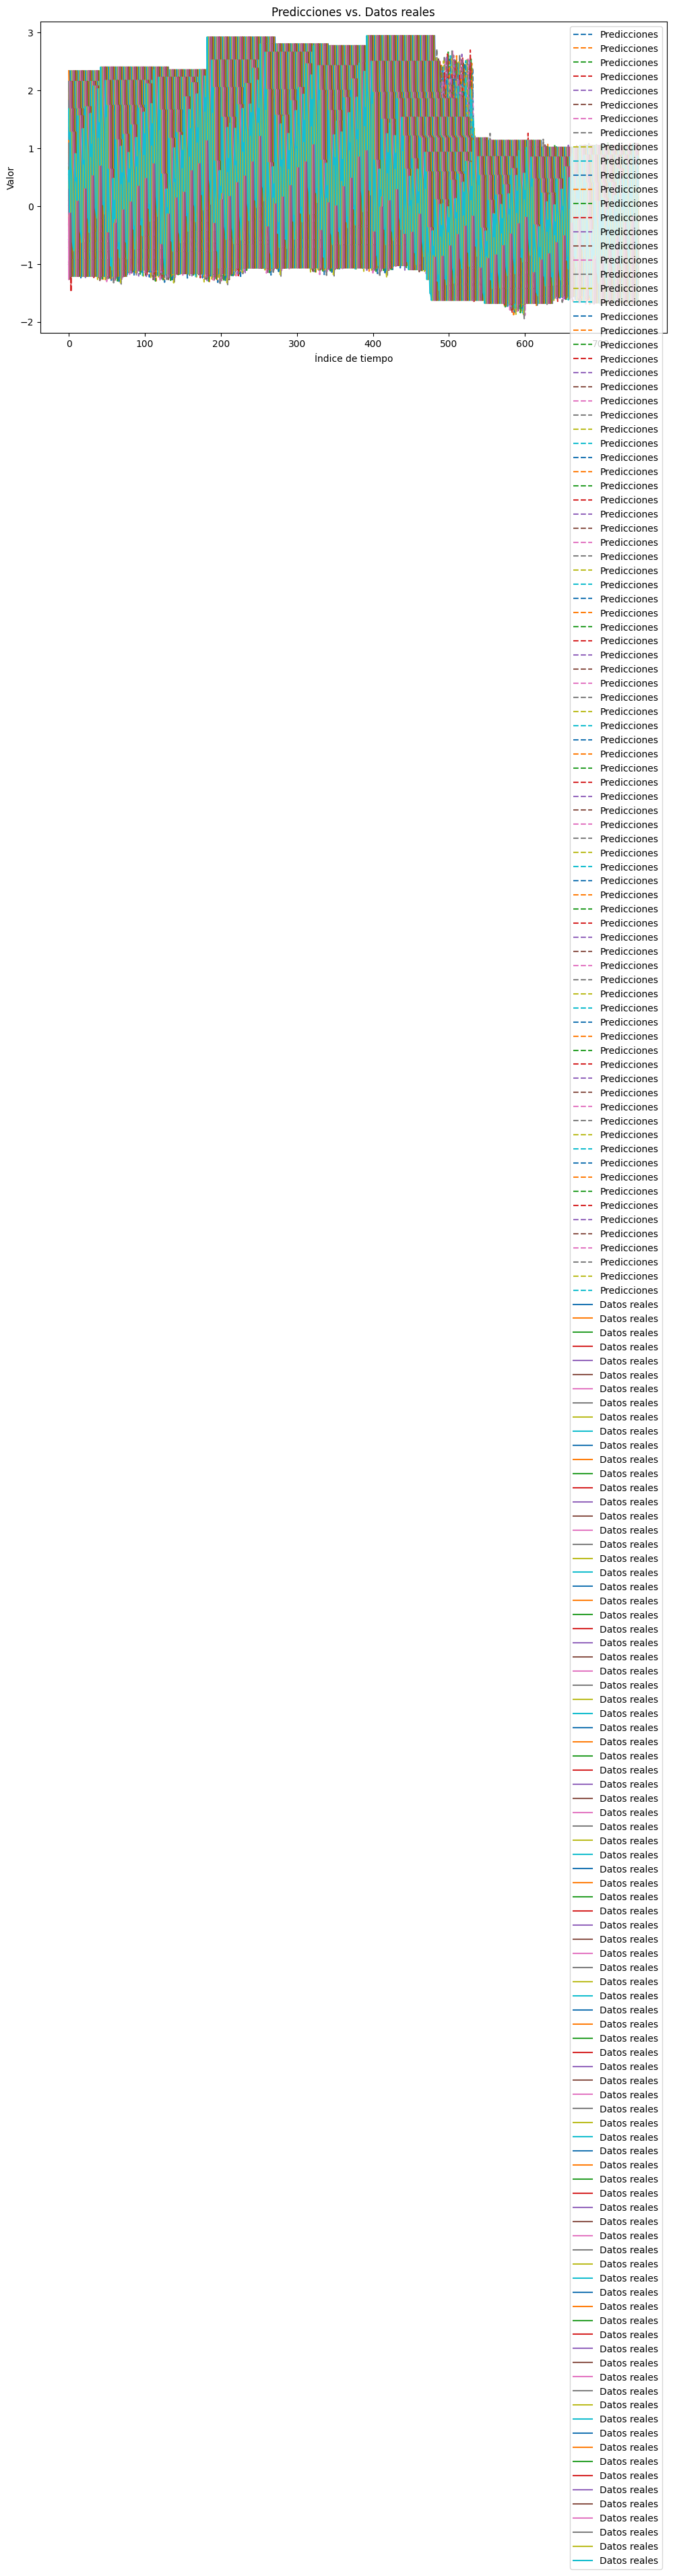

In [71]:
plt.figure(figsize=(12, 6))
plt.plot(predicciones, label="Predicciones", linestyle='--')
plt.plot(y_prueba, label="Datos reales")
plt.legend()
plt.xlabel("Índice de tiempo")
plt.ylabel("Valor")
plt.title("Predicciones vs. Datos reales")
plt.show()

In [69]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_prueba, predicciones)
mae = mean_absolute_error(y_prueba, predicciones)

print(f"Error Cuadrático Medio (MSE): {mse}")
print(f"Error Absoluto Medio (MAE): {mae}")

Error Cuadrático Medio (MSE): 0.13408598216916978
Error Absoluto Medio (MAE): 0.21639157300147802
